In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv2

import torch
import torch.nn as nn
import torch.optim as optim
import random

import torchvision
import torchvision.utils
from torchvision.models import detection
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import dataset as data
import utils as utils
import pickle
import attackMethods as am

print(torch.__version__)

1.10.0+cu113


In [54]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

dataset = data.AdversarialDataset() # todo: use resize to pull picture in batch

loss = am.lossObjectness


batch_size = 128

train_loader  = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cpu")
#device = torch.device("cuda:0")
#'cuda:0' or 'cpu'

In [82]:
#train on pictures from dset (pictures with persons in personIndex list)

model.eval()
model = model.float().to(device)

patch = am.generatePatch()
patch = patch.to(device)

TVCoeff = 0.00000001
GradRate = 0.05

#personIndex = []

epoches = 5

for epoch in range(epoches):
    patch = am.generatePatch()
    for i in personIndex:
        image, label = dataset[i]

        patch.requires_grad = True
        attackedImage = data.ImToTen(image)

        attackedImage = attackedImage.to(device)
        attackedImage.requires_grad = True

        wasPerson = False

        for l in label:
            if l["category_id"] == 1:
                wasPerson = True
                attackedImage = am.setPatch(attackedImage, patch, l['bbox'], 0.2, device) 

        if wasPerson:
            #personIndex.append(i)

            cost = loss(label, model([attackedImage])[0]) + TVCoeff * am.TV(patch)
            grad = torch.autograd.grad(cost, patch, retain_graph=False, create_graph=False,  allow_unused=True)[0]
            patch.requires_grad = False
            if grad != None:
                patch = patch - GradRate*grad.sign()

        print("ep:", epoch,"image:", i," loss:", cost)
        
    utils.SavePatch(patch, "patch - " + str(epoch))




ep: 0 image: 0  loss: tensor(1.1094, grad_fn=<AddBackward0>)
ep: 0 image: 1  loss: tensor(1.1075, grad_fn=<AddBackward0>)
ep: 0 image: 2  loss: tensor(1.1275, grad_fn=<AddBackward0>)
ep: 0 image: 3  loss: tensor(1.1034, grad_fn=<AddBackward0>)
ep: 0 image: 4  loss: tensor(1.1069, grad_fn=<AddBackward0>)
ep: 0 image: 5  loss: tensor(1.5364, grad_fn=<AddBackward0>)
ep: 0 image: 6  loss: tensor(1.1103, grad_fn=<AddBackward0>)
ep: 0 image: 8  loss: tensor(1.2058, grad_fn=<AddBackward0>)
ep: 0 image: 9  loss: tensor(1.1502, grad_fn=<AddBackward0>)
ep: 0 image: 13  loss: tensor(1.6535, grad_fn=<AddBackward0>)
ep: 0 image: 16  loss: tensor(1.3176, grad_fn=<AddBackward0>)
ep: 0 image: 18  loss: tensor(1.1622, grad_fn=<AddBackward0>)
ep: 0 image: 20  loss: tensor(1.1113, grad_fn=<AddBackward0>)
ep: 0 image: 23  loss: tensor(1.1031, grad_fn=<AddBackward0>)
ep: 0 image: 24  loss: tensor(1.1595, grad_fn=<AddBackward0>)
ep: 0 image: 25  loss: tensor(1.1342, grad_fn=<AddBackward0>)
ep: 0 image: 26  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


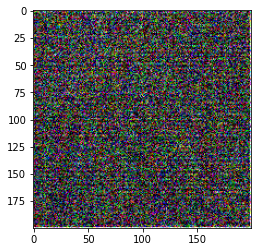

In [79]:
utils.ShowPatch(patch)

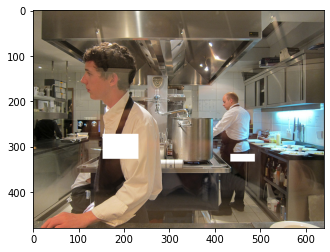

In [56]:
image, label = dataset[personIndex[7]]
utils.ShowImageWithPatch(image, label, patch, device)

In [19]:
patch = utils.LoadPatch("patch")

In [ ]:
utils.SavePatch("patch")

In [51]:
with open('0_624.pickle', 'rb') as f:
    personIndex = pickle.load(f)

In [68]:
image, label = dataset[personIndex[7]]
patch = utils.TrainOneImage(model, loss, image, label, epoches=10)

ep: 0  loss: tensor(1.1819, grad_fn=<AddBackward0>)
ep: 1  loss: tensor(1.1061, grad_fn=<AddBackward0>)
ep: 2  loss: tensor(1.0346, grad_fn=<AddBackward0>)
ep: 3  loss: tensor(0.9632, grad_fn=<AddBackward0>)
ep: 4  loss: tensor(0.8850, grad_fn=<AddBackward0>)
ep: 5  loss: tensor(0.8303, grad_fn=<AddBackward0>)
ep: 6  loss: tensor(0.7588, grad_fn=<AddBackward0>)
ep: 7  loss: tensor(0.6875, grad_fn=<AddBackward0>)
ep: 8  loss: tensor(0.6162, grad_fn=<AddBackward0>)
ep: 9  loss: tensor(0.5449, grad_fn=<AddBackward0>)
